# 딥러닝(LSTM)에 의한 감정분석

# 환경설정

사람의 정서적 상태와 주관적 정보를 체계적으로 식별, 추출하는 연구

* 로지스틱 회귀 방법에 의한 분석
* 딥러닝 방법에 의한 분석

고려해주어야할 것
1. 여러가지 comment 내용 -> 긍정인지 부정인지 라벨링 -> word embedding sentence embedding시에 단어 사전이 필요
2. 토큰의 수를 counting해서 outlyer를 짤라줌(길이 맞춰주기)=입력 feature 수

In [ ]:
#Q&A
for row in df.iterrows():
  print(row)
#iterrows()는 열을 추출하는 함수

In [1]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
# 여기까지 실행 후 "런타임 다시 시작..." 실행 (이 부분은 실행할 필요 없음)

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
data_dir = '/content/drive/MyDrive/Data/'
os.listdir(data_dir)

['kowiki',
 '감성대화',
 'sc_training.json',
 'sc_corpus.txt',
 'sc_training.csv',
 'corpus_mecab.txt',
 'GoogleNews-vectors-negative300.bin.gz',
 'w2v.model',
 'ko_vocab',
 'juso',
 'songys-chat',
 'downstream_exported',
 'myproject',
 'research.txt',
 'movie_comment.csv',
 'nsmc',
 'vocab_ex']

In [ ]:
nsrs_dir = os.path.join(data_dir, "myproject")
if not os.path.isdir(nsrs_dir):
    os.makedirs(nsrs_dir)
os.listdir(nsrs_dir)

['hotel.hdf5',
 'hotel.csv',
 'tripadviser_review.csv',
 'movie.hdf5',
 'movie.csv']

# 1.환경 변수 설정 및 데이터 탐색

패딩 : 이제 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

In [ ]:
!pip install sentencepiece

In [ ]:
# vocab loading
import sentencepiece as spm
vocab = spm.SentencePieceProcessor()
vocab.load('/content/drive/MyDrive/Data/kowiki/kowiki_32000.model')

True

In [ ]:
# 구글드라이브 영화자료 불러와서 사용
df = pd.read_csv('/content/drive/MyDrive/Data/movie_comment.csv', index_col=False)[['Score','Comment']]
df

,Score,Comment
0,1,대놓고 2편의 예고편....나중에 2편나올때 케이블에서 다시보면될정도...
1,6,난또 라스트제다이 스핀오프편인줄 알았네..ㅡㅡ
2,10,단순한 우주재난 영화가 아닌 '죽음과 삶'이라는 주제를 담고 있는 영화.. 최고의 ...
3,10,큰 기대 없이 지나가다가 TV에서 광고만 보고 재밌겠다 싶어서 봤는데 ㅋㅋㅋ 생각보...
4,10,'두려움은 마음을 죽인다. 두려움이 사라지면 나만 오롯이 남는다.' 이미 다음편이 ...
...,...,...
9985,2,디 오리지널은 개뿔 앞뒤 다 잘라놓고 오리지널? 오리지널 뜻 모르냐?
9986,10,보고나서도 입꼬리가 내려가질 않아요ㅎㅎ 건강한 코미디라는 말이 딱 맞는듯. 영화관에...
9987,10,소재가 독특한데 19금 유머와 함께여서 자칫 어두울 수 있는 현실이 웃음으로 잘 승...
9988,10,실화를 떠나 몰입할 수 밖에 없는 스토리.. 실감나는 배우들의 연기력.. 실화와 관...


In [ ]:
# document 길이 데이터, n_seq(입력피처의 수)를 결정하기 위해
train_length = df["Comment"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
train_length.head(10)

0    26
1    20
2    25
3    44
4    29
5    14
6    14
7    59
8    16
9    18
Name: Comment, dtype: int64

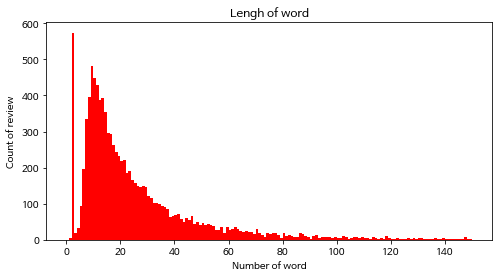

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=150, range=[0, 150], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"token 길이 최대:    {np.max(train_length):4d}")
print(f"token 길이 최소:    {np.min(train_length):4d}")
print(f"token 길이 평균:    {np.mean(train_length):7.2f}")
print(f"token 길이 표준편차: {np.std(train_length):7.2f}")

token 길이 최대:     483
token 길이 최소:       1
token 길이 평균:      27.37
token 길이 표준편차:   33.08


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"token 25/100분위:  {percentile25:7.2f}")
print(f"token 50/100분위:  {percentile50:7.2f}")
print(f"token 75/100분위:  {percentile75:7.2f}")
print(f"token IQR:        {percentileIQR:7.2f}")
print(f"token MAX/100분위: {percentileMAX:7.2f}")

token 25/100분위:    10.00
token 50/100분위:    17.00
token 75/100분위:    32.00
token IQR:          22.00
token MAX/100분위:   65.00


In [ ]:
# 앞으로 패딩입력을 위한 표준 최대 토큰수 졀정 
n_seq = 65

In [ ]:
id_to_label = {0: "부정", 1: "긍정"}

In [ ]:
# 점수를 기준으로 긍정(4,5)과 부정(1-3)으로 변환
def rating_to_label(rating):
    if rating > 6:
        return 1
    else:
        return 0
    
df['y'] = df['Score'].apply(lambda x: rating_to_label(x))

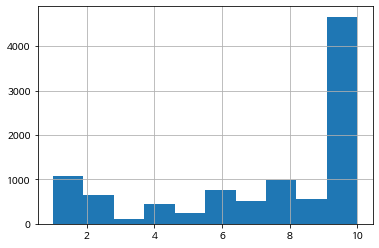

In [ ]:
# 점수별 빈도수
df['Score'].hist()

1    6715
0    3275
Name: y, dtype: int64


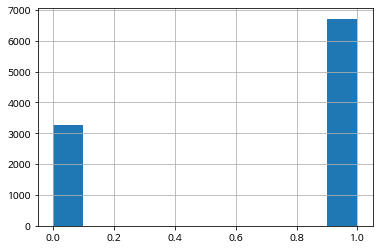

In [ ]:
# 점수별 빈도수, 부정6715 긍정3275
print(df['y'].value_counts())
df['y'].hist()

In [ ]:
# 데이터 정리
df = df[['y', 'Comment']]
df

,y,Comment
0,0,대놓고 2편의 예고편....나중에 2편나올때 케이블에서 다시보면될정도...
1,0,난또 라스트제다이 스핀오프편인줄 알았네..ㅡㅡ
2,1,단순한 우주재난 영화가 아닌 '죽음과 삶'이라는 주제를 담고 있는 영화.. 최고의 ...
3,1,큰 기대 없이 지나가다가 TV에서 광고만 보고 재밌겠다 싶어서 봤는데 ㅋㅋㅋ 생각보...
4,1,'두려움은 마음을 죽인다. 두려움이 사라지면 나만 오롯이 남는다.' 이미 다음편이 ...
...,...,...
9985,0,디 오리지널은 개뿔 앞뒤 다 잘라놓고 오리지널? 오리지널 뜻 모르냐?
9986,1,보고나서도 입꼬리가 내려가질 않아요ㅎㅎ 건강한 코미디라는 말이 딱 맞는듯. 영화관에...
9987,1,소재가 독특한데 19금 유머와 함께여서 자칫 어두울 수 있는 현실이 웃음으로 잘 승...
9988,1,실화를 떠나 몰입할 수 밖에 없는 스토리.. 실감나는 배우들의 연기력.. 실화와 관...


# 2.Train, Test 데이터 생성

### 방안1. 기존방법

In [ ]:
# 전체 데이터를 train 데이터 70%, test 데이터 30%로 분리
# 1 기존방법 df 적용,  2. undersampling으로 하면 new_df 입력 
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df, test_size = 0.3, random_state=256) # 1방안 
df_test = df_test.dropna()
df_test

,y,Comment
8659,0,"전형적으로 초반, 중반, 후반이 따로 노는 영화"
5725,0,그럭저럭. 1탄보다는 아쉽다.
1099,0,하 어라이벌 블레이드러너만 보고 바로 걸럿어야했는데 이걸 못 피했네..
8454,0,쿠키영상만 볼만함….
5444,0,연기력이 일단 바닥이고 연출력 스토리 뭐하나 제대로 된게 없는 아마추어 수준의 영화.
...,...,...
2979,1,우리가 영화를 사랑하는 이유 중 하나를 들려줬다.
7188,1,생각보다 뻔한 연출이다보니 오히려 배우들 연기력이 더 잘보이게된 케이스가 아닌가 싶...
6578,0,손에 땀을 쥐는 플롯이나 주제로 찰떡같이 귀결되는 연출 같은건 없다. 그냥 미국에사...
1914,1,그냥 너랑 봐서 좋았던 것 같다


### 방안 2.불균형문제 해결 Vs. 데이터 손실   

In [ ]:
# under-sampling 방법으로 불균형 해소 : 550개 샘플만 적용하여 학습 및 평가 
positive_random_idx = df[df['y']==1].sample(3275, random_state=12).index.tolist()
negative_random_idx = df[df['y']==0].sample(3275, random_state=12).index.tolist()
random_idx = positive_random_idx + negative_random_idx
x = df['Comment'][random_idx]
y = df['y'][random_idx]
new_df = pd.concat([y,x],axis=1)
new_df

,y,Comment
3247,1,이해하면 굉장히 재미있는 영화!인간의 본질에 대해 생각하면 깨달음이 있고 나 자신도...
5508,1,전 개인적으론 재밌었어요. 솔직히 좀 지루함..ㅎㅎ
733,1,1초도 지루함이 없다. 미쳤다!
8148,1,NaN
6614,1,노회찬 의원님.. 그립습니다 대한민국 진보정치의 미래 이셨던분..
...,...,...
6381,0,쿠키영상을 보기위한 영화
4260,0,그냥 그랬음 칼질만 기억남
4594,0,<오징어게임>과 고교남자기숙사를 합하면?
5459,0,3년 전의 1편도 솔직히 별로였었지만 이번 2편은 역대 마블 영화들중 최악. 러닝 ...


In [ ]:
# 전체 데이터를 train 데이터 70%, test 데이터 30%로 분리
# 1 기존방법 df 적용,  2. undersampling으로 하면 new_df를 입력 
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df, test_size = 0.3, random_state=256) # 2방안 

df_test = df_test.dropna()
df_test  

,y,Comment
8659,0,"전형적으로 초반, 중반, 후반이 따로 노는 영화"
5725,0,그럭저럭. 1탄보다는 아쉽다.
1099,0,하 어라이벌 블레이드러너만 보고 바로 걸럿어야했는데 이걸 못 피했네..
8454,0,쿠키영상만 볼만함….
5444,0,연기력이 일단 바닥이고 연출력 스토리 뭐하나 제대로 된게 없는 아마추어 수준의 영화.
...,...,...
2979,1,우리가 영화를 사랑하는 이유 중 하나를 들려줬다.
7188,1,생각보다 뻔한 연출이다보니 오히려 배우들 연기력이 더 잘보이게된 케이스가 아닌가 싶...
6578,0,손에 땀을 쥐는 플롯이나 주제로 찰떡같이 귀결되는 연출 같은건 없다. 그냥 미국에사...
1914,1,그냥 너랑 봐서 좋았던 것 같다


### 공통적용

In [ ]:
# 1. 훈련용 데이터 정리
df_train = df_train.dropna()
df_train

,y,Comment
4700,1,가볍게 보기좋은 코믹재난영화입니다
1904,1,와 대박 간만에 ㅎㅎ 푹빠져 봤습니다
1446,0,개연성이 너무 없더라~~~
5601,1,진짜 구라 1도안섞고 개재밌음 베놈 보고오니까 확실히 느껴진다 이건 수작이다.
4187,0,정말 고구마도 이런 고구마 영화가 없다. 정말 멘탈나가게하는 답답함의 연속인 영화
...,...,...
9523,1,베놈은 베놈이네 ㅋㅋㅋ 꼭 극장에서 보시길
1776,1,무난하다...
7233,1,1편보다 재미없다 액션도 그닥
423,0,영화시작한후 10분후 그냥… 잤다… OOO


In [ ]:
#3. n_seq 확인, 입력 피처의 길이65로 지정
n_seq 

65

In [ ]:
# input 데이터와 라벨을 리턴해주는 함수 : 1. 입력변수 자료 데이터프레임, 2. 단어사전 vacab, 3. 토큰 최대입력 길이(패딩기준) n_seq 
# 토큰의 최대입력길이 n_seq = percentile75 + percentileIQR(percentile75 -percentile25 ) * 1.5(즉, outlier만 제거하는 수준)
from tqdm.notebook import tqdm, trange

def make_data(df, vocab, n_seq):
    inputs, labels = [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        label = row["y"]
        document = row["Comment"]

        token = vocab.encode_as_ids(document)
        token = token[:n_seq]
        token = token + [0] * (n_seq - len(token))
        assert len(token) == n_seq
        # print(label, len(token), token)
        inputs.append(token)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(df_train, vocab, n_seq)
train_inputs, train_labels

  0%|          | 0/6602 [00:00<?, ?it/s]

(array([[20219,  4569, 17851, ...,     0,     0,     0],
        [   10,    25,   235, ...,     0,     0,     0],
        [  760,   344,  1409, ...,     0,     0,     0],
        ...,
        [   36,   946,   319, ...,     0,     0,     0],
        [  284,    56,   919, ...,     0,     0,     0],
        [  311,    75,   427, ...,     0,     0,     0]]),
 array([1, 1, 0, ..., 1, 0, 0]))

In [ ]:
#(입력데이터의수,n_seq), 라벨의 벡터값
train_inputs.shape, train_labels.shape

NameError: ignored

In [ ]:
test_inputs, test_labels = make_data(df_test, vocab, n_seq)
test_inputs, test_labels

  0%|          | 0/2830 [00:00<?, ?it/s]

(array([[ 5665,    27,  4391, ...,     0,     0,     0],
        [   34,  7130,   651, ...,     0,     0,     0],
        [  420,   540,  3491, ...,     0,     0,     0],
        ...,
        [ 6170, 24186,    11, ...,     0,     0,     0],
        [   34,  4906,  5331, ...,     0,     0,     0],
        [   72,    60,  1996, ...,     0,     0,     0]]),
 array([0, 0, 0, ..., 0, 1, 0]))

In [ ]:
test_inputs.shape, test_labels.shape

((2830, 65), (2830,))

# 3.Modeling

In [ ]:
#사전 설정을 위해
import argparse
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
args.n_vocab = len(vocab) 
args.d_model = 256 #depth
args.n_out = 2 #출력값
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
# 모델 정의 
import tensorflow as tf

#word embedding의 과정
def build_model(args):
    inputs = tf.keras.layers.Input((None,))

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)
    
    # modeling 선택 입력 부분 : RNN, CNN, Attention, Linear 등으로 입력 
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))
    hidden = lstm(hidden)
    # 입력 피처중에 의미 있는 데이터를 뽑아줌
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden = pool(hidden)
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax) #출력되는 칼럼에 확률값으로 반환해줌
    y_pred = linear(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

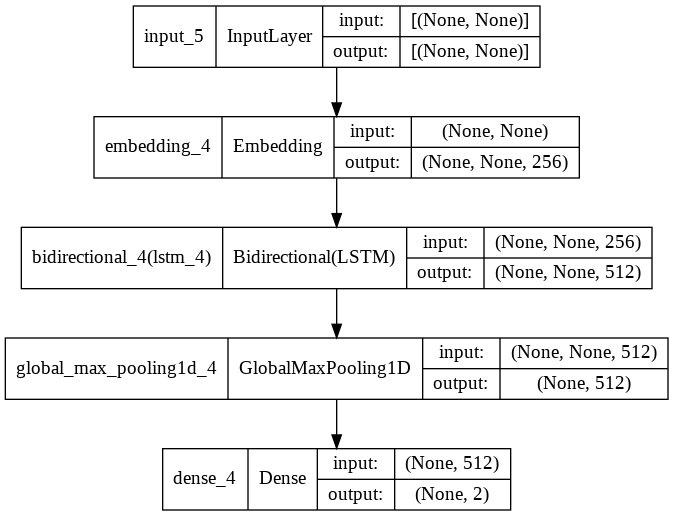

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)
#(batch size, n_seq, depth)

In [ ]:
#아직은 학습이 충분하게 되지않은 상태
model.predict(train_inputs[:4])

array([[0.49838048, 0.5016196 ],
       [0.49451354, 0.5054864 ],
       [0.49665913, 0.5033409 ],
       [0.49915698, 0.50084305]], dtype=float32)

In [ ]:
model.predict(test_inputs[:4])

array([[0.5003976 , 0.49960235],
       [0.500329  , 0.49967098],
       [0.4994722 , 0.5005278 ],
       [0.5002351 , 0.49976492]], dtype=float32)

# 4.Train

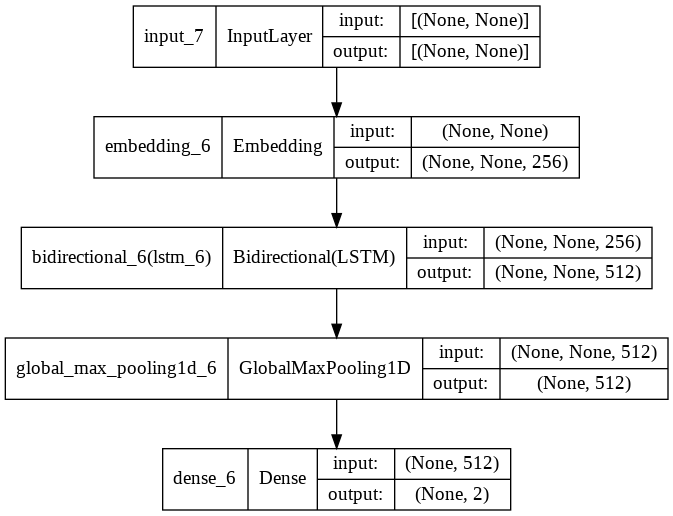

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30) #동일한 값이 몇번 나오면 stop해줄것인가
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(data_dir, 'myproject', "movie.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(data_dir,'myproject', "movie.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=256,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

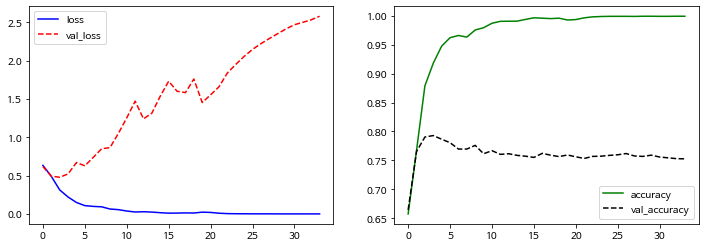

In [ ]:
#validation loss가 거꾸로 높아지는 현상, validation accuracy는 반대로 떨어진다=overfitting 된다
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss') #b는 blue
plt.plot(history.history['val_loss'], 'r--', label='val_loss') # r은 red색상 --두번은 점선 --으로 하라
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy') #g는 green색상
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy') #k는 black색상
plt.legend()

plt.show()

# 5.평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(data_dir,'myproject', "movie.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate(test_inputs, test_labels)

89/89 [==============================] - 5s 22ms/step - loss: 0.5232 - accuracy: 0.7929


[0.5231500267982483, 0.7929328680038452]

In [ ]:
y_pred = model.predict(test_inputs)
y_pred

array([[0.95120335, 0.04879663],
       [0.92991984, 0.07008015],
       [0.3952415 , 0.6047585 ],
       ...,
       [0.14577378, 0.8542262 ],
       [0.23683235, 0.7631677 ],
       [0.4307767 , 0.5692233 ]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1) #axis=-1 열간의 비교, axis=-2 행간의 비교
y_class

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
#0인것을 0으로 1인것을 1로
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[ 627,  344],
       [ 242, 1617]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 0.1)
print(f'f1: {f1}')

accuracy: 0.7929328621908127
precision: 0.8245792962774094
recall: 0.8698224852071006
f1: 0.8465968586387435


# 6.배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(data_dir,'myproject', "movie.hdf5"))

In [ ]:
string = "영화가 너무 심심해요"

In [ ]:
vocab.encode_as_pieces(string)

['▁영화', '가', '▁너무', '▁심', '심', '해', '요']

In [ ]:
infer_input = vocab.encode_as_ids(string)
infer_input = np.array([infer_input])
infer_input

array([[ 284,   19, 2360,  732,  690,   61,  489]])

In [ ]:
train_inputs.shape, infer_input.shape

((6602, 65), (1, 7))

In [ ]:
y_pred = model.predict(infer_input)
y_pred

array([[0.6559872 , 0.34401286]], dtype=float32)

In [ ]:
import numpy as np
y_class = np.argmax(y_pred, axis=-1)[0]
print(f"{string} : {id_to_label[y_class]}")

영화가 너무 심심해요 : 부정


In [ ]:
def do_predict(model, string):
    infer_input = vocab.encode_as_ids(string)
    infer_input = np.array([infer_input])

    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
do_predict(model, string)

'부정'

In [ ]:
while True:
    print("input> ", end="")
    string = str(input())
    if len(string) == 0:
        break
    result = do_predict(model, string)
    print(result)

input> 영화 재미없어요
부정
input> 배우들이 연기를 너무 잘합니다
긍정
input> 너무 심심해
부정
input> 다음에 다시 보고싶어요
긍정
input> 
